# Defect analysis for membranes

This module identifies membrane packing defects using a grid-based algorithm and atom classification rules. You can run the analysis interactively or via command-line interface.

### Option 1: Interactive Class-Based Usage (in Jupyter or Scripts)

The `PackingDefectAnalyzer` class gives you full control over defect identification, trajectory processing, and result visualization.



In [1]:
import sys, os
import json
import MDAnalysis as mda

# --- Make sure project root is in sys.path ---
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# --- Import refactored classes ---
from packing_defect.core.classification import DefaultClassification
from packing_defect.core.topology import TopologyReader
from packing_defect.core.analyzers.packing import PackingDefectAnalyzer
from packing_defect.run_utils import run_analysis


In [2]:
# --- Load radii.json ---
with open("../packing_defect/data/radii.json") as f:
    types_radii = json.load(f)

# --- Build residue radii maps from CHARMM topology ---
topo_reader = TopologyReader(types_radii, DefaultClassification().classify)
radii = {
    "POPC": topo_reader.read("POPC", "../packing_defect/data/top/top_all36_lipid.rtf"),
    "TRIO": topo_reader.read("TRIO", "../packing_defect/data/top/TRIO.rtf"),
    "DOPE": topo_reader.read("DOPE", "../packing_defect/data/top/top_all36_lipid.rtf"),
}

# --- Load trajectory ---
u = mda.Universe("../../../mlx.gro", "../../../rep1_skip10.xtc")
selection = u.select_atoms("resname POPC TRIO DOPE")

Processing frame 0, time: 0.000, pbc: [ 95.3022  95.3022 253.9081]
Processing frame 1, time: 1000.000, pbc: [ 95.30498  95.30498 255.94632]
Processing frame 2, time: 2000.000, pbc: [ 95.8701   95.8701  253.47928]
Processing frame 3, time: 3000.000, pbc: [ 95.78892  95.78892 253.33582]
Processing frame 4, time: 4000.000, pbc: [ 96.32755  96.32755 250.49126]
Processing frame 5, time: 5000.000, pbc: [ 96.400444  96.400444 250.48914 ]
Processing frame 6, time: 6000.000, pbc: [ 95.99199  95.99199 252.3247 ]
Processing frame 7, time: 7000.000, pbc: [ 95.57365  95.57365 255.14526]
Processing frame 8, time: 8000.000, pbc: [ 95.56029  95.56029 254.1786 ]
Processing frame 9, time: 9000.000, pbc: [ 96.07506  96.07506 251.77385]


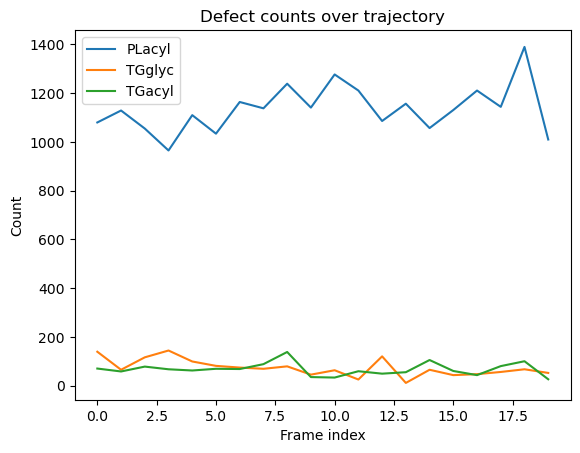

[BaseDefectAnalyzer] Results written to results_defect/results.txt


In [3]:
# --- Create analyzer (new API: universe is passed explicitly) ---
analyzer = PackingDefectAnalyzer(
    universe=u,
    atomgroups=[selection],
    radii=radii,
    output_dir="results_defect",  # now matches BaseDefectAnalyzer naming
    leaflet="both",
    defect_types=["PLacyl", "TGglyc", "TGacyl"],
    defect_thresholds={"PLacyl": 1, "TGglyc": 2, "TGacyl": 3},
    start=0, stop=10, stride=1
)

# --- Run + plot using generic runner ---
run_analysis(analyzer)

### Option 2: Script-Style Execution via python -m (works in shell or notebooks)

If you prefer reproducible batch-style runs, use the included command-line interface:

In [2]:
%cd ..

!python -m packing_defect.run_defect \
  --top packing_defect/data/traj/6.6_2.gro \
  --traj packing_defect/data/traj/rep3_skip100.xtc \
  --out results_defect \
  --start 1 \
  --stop 6 \
  --stride 1


/mnt/c/users/jay/desktop/modules/analysis/github/new/packing_defect
/home/jaybraun/miniconda3/lib/python3.9/runpy.py:127: RuntimeWarning: 'packing_defect.run_defect' found in sys.modules after import of package 'packing_defect', but prior to execution of 'packing_defect.run_defect'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Processing frame 1, time: 100000.000, pbc: [ 95.29258  95.29258 255.96146]
Processing frame 2, time: 200000.000, pbc: [ 96.29352  96.29352 250.65392]
Processing frame 3, time: 300000.000, pbc: [ 97.01071  97.01071 247.05823]
Processing frame 4, time: 400000.000, pbc: [ 96.69534  96.69534 248.91089]
Processing frame 5, time: 500000.000, pbc: [ 96.78784  96.78784 247.43958]
Figure(640x480)
[BaseDefectAnalyzer] Results written to results_defect/summary.txt


# We can also do it with different defect types
For example, we have a test_json file which assigns defects to different atoms besides the defaults. 

It is important to note that you will still need the topology files in CHARMM or Gromacs format.

In [7]:
from packing_defect.core.classification import UserDictClassification

# load from JSON, auto-map "heads"/"tails" → ints
classifier = UserDictClassification.from_json("../packing_defect/data/test_json2.json")

# build topology radii
with open("../packing_defect/data/radii.json") as f:
    types_radii = json.load(f)

topo_reader = TopologyReader(types_radii, classifier.classify)
radii = {
    "POPC": topo_reader.read("POPC", "../packing_defect/data/top/top_all36_lipid.rtf"),
    "TRIO": topo_reader.read("TRIO", "../packing_defect/data/top/TRIO.rtf"),
    "DOPE": topo_reader.read("DOPE", "../packing_defect/data/top/top_all36_lipid.rtf"),
}

u = mda.Universe("../packing_defect/data/traj/6.6_2.gro",
                 "../packing_defect/data/traj/rep3_skip100.xtc")
memb = u.select_atoms("resname " + " ".join(radii.keys()))

analyzer = PackingDefectAnalyzer(
    universe=u,
    atomgroups=[memb],
    radii=radii,
    output_dir="results_defect_json",
    leaflet="both",
    defect_types=["heads", "tails"],            # still readable labels
    defect_thresholds={"heads": 1, "tails": 2}, # thresholds use mapped codes
    start=1, stop=6, stride=1
)

# analyzer.run()


Processing frame 1, time: 100000.000, pbc: [ 95.29258  95.29258 255.96146]
Processing frame 2, time: 200000.000, pbc: [ 96.29352  96.29352 250.65392]
Processing frame 3, time: 300000.000, pbc: [ 97.01071  97.01071 247.05823]
Processing frame 4, time: 400000.000, pbc: [ 96.69534  96.69534 248.91089]
Processing frame 5, time: 500000.000, pbc: [ 96.78784  96.78784 247.43958]


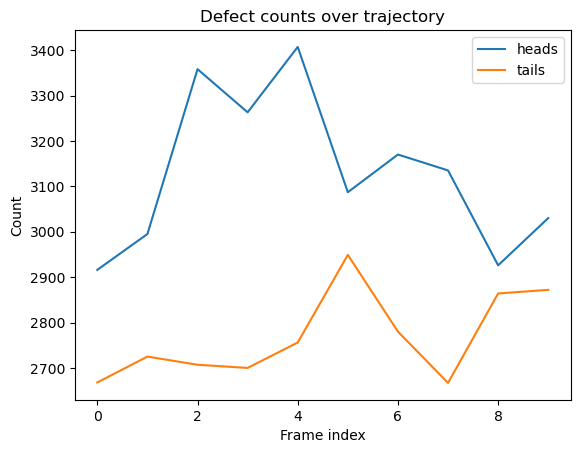

[BaseDefectAnalyzer] Results written to results_defect_json/summary.txt


In [8]:
run_analysis(analyzer)